# Thema 2 - Optimalisatie 
## Werkcollege 1


### Leerdoelen
In dit werkcollege.. 
* visualiseer je de cost surface van een model
* leer je globale en lokale minima herkennen
* fit je een niet-lineair model aan data
* ontdek je de werking van de brute force en line search methodes 
* ontleed je de werking van het gradient descent algoritme
* beredeneer je de voor- en nadelen van deze methodes
* leer je de numpy, scipy, plotly en tqdm libraries gebruiken

In [3]:
# De libraries voor deze les
import pandas as pd                           # pip install pandas
import numpy as np

from numpy import array, zeros, linspace      # pip install numpy
from numpy import sin, cos, pi, exp, sum, arange

import numpy.random                           # pip install numpy
import pylab as plt                           # pip install matplotlib
from scipy.optimize import minimize, brute    # pip install scipy
from datetime import datetime

import plotly.graph_objects as go         # pip install ipywidgets jupyter-dash plotly
                                          # jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyterlab-plotly

from typing import Callable, Tuple
from tqdm import tqdm                     # pip install tqdm

## Regressieprobleem
In deze les gaan we aan de slag met het fitten van een model aan een reeks datapunten. Dit is niet vreemde stof. Het is namelijk de basis van waar we ook met de LASSO en lineaire regressie technieken werken. 

Bij lineaire regressie is er sprake van een vast model: $Y = aX+b$. Hierbij probeer je op basis van je invoerkolom/-kolommen $X$ en parameters $a$ en $b$, een voorspelling te doen voor je kolom $Y$. Vaak heb je daarbij een trainingsset met data voor zowel $X$ als $Y$, waarmee je de parameters kunt _trainen_. Het _trainen_ van een model om de juiste parameters te leren noemen we ookwel een _optimalisatieprobleem_. 

We gaan in dit thema een stap verder. In plaats van een voorgedefinieërd model, willen we onze eigen modelen bouwen. Zo'n model zal altijd een paar parameters bevatten, de draaiknoppen waarmee je het model kan koppelen. Hoe kun je de optimale parameters vinden? 

### Business Understanding
Als onderwerp gaan we aan de slag met lasers. Veel van het internetverkeer gaat tegenwoordig over glasvezels. Hierin schieten lasers kleine pulsen licht door de kabel, die kilometers verderop weer ontvangen worden. Zo'n laserpuls is niet slechts een simpele 'uit-aan-uit'. In plaats daarvan is het een signaal waarbij de intensiteit op en neer gaat. In de onderstaande grafiek laten we je een voorbeeld zien.

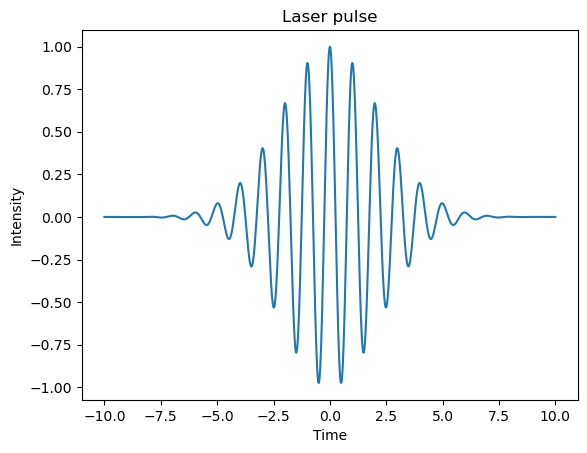

In [4]:
def model_laserpulse(t, params):
    (a, T0) = params
    t = t - T0
    return exp(-(t/a)**2) * cos(2 * pi * t)

t = linspace(-10, 10, 1000)    # array met de tijd
y = model_laserpulse(t, (pi, 0))  # array met de intensiteit

_ = plt.plot(t, y)
_ = plt.title("Laser pulse")
_ = plt.xlabel("Time")
_ = plt.ylabel("Intensity")

Zoals je ziet is dit een complexe grafiek. Hier kun je geen rechte lijn aan fitten, dus een lineaire regressie zal hier niet werken. Gelukkig is dat ook niet nodig. We weten namelijk het juiste model. Dat wordt gegeven door de functie _laserpuls_. In dit geval met de parameters $\textrm(pi)$ en 0. 

De vraag is dus: Als we niet de parameters weten, hoe kunnen we dan toch dit model fitten?

### Data Understanding
Om met deze vraag aan de slag te gaan, moeten we als eerste een model dataset maken. We maken wederom gebruik van de functie _laserpuls_, maar nemen nu net wat andere waarden als parameters: (1, 2). We voegen ook een klein beetje ruis toe.

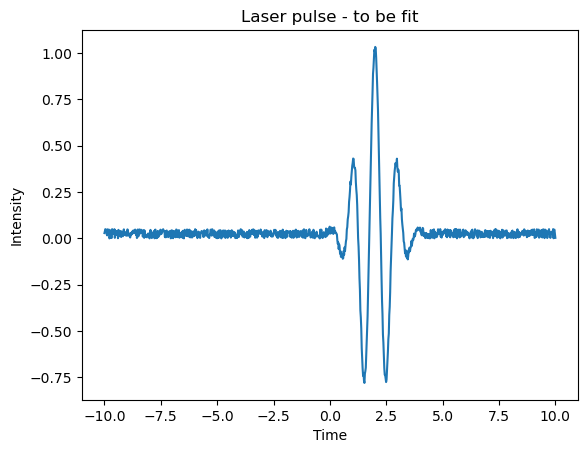

In [5]:
y_target = model_laserpulse(t, (1, 2)) + numpy.random.random(t.shape) * 0.05
_ = plt.plot(t, y_target)
_ = plt.title("Laser pulse - to be fit")
_ = plt.xlabel("Time")
_ = plt.ylabel("Intensity")

### Data Preparation
Niet van toepassing

### Modeling - Brute Force
Het doel is van de optimalisatie is dus om de waarden van de parameters te ontdekken. Hiervoor hebben we een manier nodig om de echte resultaten met het model te vergelijken. Vanuit het vorige thema kennen we die al: de _mean squared error_ (MSE). We gebruiken deze om een _cost functie_ te definiëren.

In [6]:
def MSE(y1, y2) -> float:
    return sum((y1 - y2)**2) / len(y1)

def cost_function(params, y_target, t):
    y_model = model_laserpulse(t, params)
    return MSE(y_model, y_target)

We zijn op zoek naar de parameters die de laagste MSE opleveren. Idealiter is dat 0, in de praktijk zal het er altijd boven zitten door ruis.

De eerste methode die we gaan proberen is de zogenaamde _brute force_ methode. Hierbij proberen we simpelweg alle combinaties. We starten simpel en nemen aan dat de eerste parameter $a$ gelijk is aan 1. We hoeven dus alleen voor de eerste parameter $T_0$ te zoeken.

#### Opdracht
- Schrijf een loop waarbij je steeds een model maakt en daarvan de cost van alle mogelijke waarden van T0 tussen de -5 en 5 berekent. Neem daarbij tussenstapjes van 0.1
- Houd de waarde van a voor nu vast op 1
- Sla voor elke poging de bijbehorende MSE op
- Is het optimum gevonden?
- Hoeveel stappen heb je hiervoor geprobeerd?

In [7]:
# Arrays voor T0 en kosten (MSE)
T0_values = np.arange(-5, 5.1, 0.1)
costs = []

# Start tijdmeting
start_time = datetime.now()

# Loop over alle mogelijke waarden van T0
a_fixed = 1  # vaste waarde van a
for T0 in T0_values:
    params = (a_fixed, T0)
    cost = cost_function(params, y_target, t)
    costs.append(cost)

# Bepaal de optimale T0 waarde (die met de laagste MSE)
optimal_T0_index = np.argmin(costs)
optimal_T0 = T0_values[optimal_T0_index]
min_cost = costs[optimal_T0_index]

# Stop tijdmeting
end_time = datetime.now()
duration = end_time - start_time
duration_seconds = duration.total_seconds()

# Resultaten
print(f"Optimum gevonden bij T0 = {optimal_T0:.2f}, met een minimale MSE van {min_cost:.5f}")
print(f"Aantal stappen geprobeerd: {len(T0_values)}")
print(f"Berekeningstijd: {duration_seconds:.2f} seconden")

Optimum gevonden bij T0 = 2.00, met een minimale MSE van 0.00085
Aantal stappen geprobeerd: 101
Berekeningstijd: 0.01 seconden


Uitleg van de code:
1. **Laserpuls model:** Dit model simuleert de laserpuls op basis van de parameter *a* en T0, waarbij *a* constant is op 1 en T0 varieert tussen -5 en 5.
2. **MSE-functie:** De mean squared error wordt berekend tussen de gesimuleerde data en de gegeven target data (met toegevoegde ruis).
3. **Cost-functie:** Deze functie berekent de kosten (MSE) voor een gegeven paar parameters *a* en T0.
4. **Brute force:** We voeren een loop uit over alle mogelijke waarden van T0 tussen -5 en 5 (met een stapgrootte van 0.1). Voor elke waarde berekenen we de MSE en slaan deze op.
5. **Optimum:** Nadat we alle waarden van T0 hebben doorlopen, bepalen we welke T0 de laagste MSE oplevert (dat is ons optimum).

#### Opdracht
- Plot de verschillende geprobeerde waarden van T0 ten opzichte van de gevonden MSE
- PLot met behulp van een verticale lijn ook de locatie van de beste T0 (hint: plt.axvline)
- We noemen een grafiek zoals deze het cost-landscape 
- Wat valt je op aan de grafiek? Is dit een globaal of lokaal minimum probleem


6. **Visualisatie:** We visualiseren de MSE voor elke waarde van T0 en markeren het optimale punt op de grafiek.

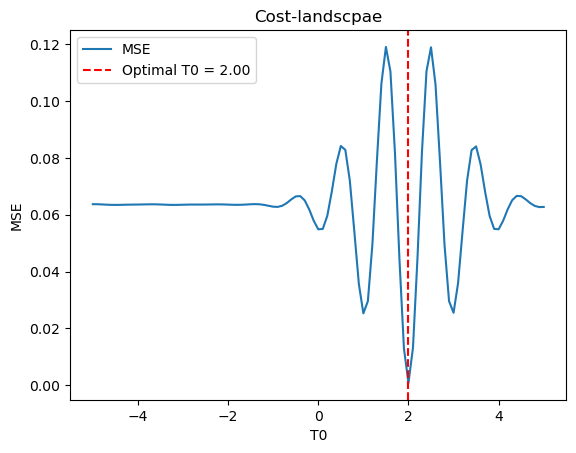

In [8]:
# Plot de kostenfunctie
plt.plot(T0_values, costs, label='MSE')
plt.axvline(optimal_T0, color='r', linestyle='--', label=f'Optimal T0 = {optimal_T0:.2f}')
plt.title('Cost-landscpae')
plt.xlabel('T0')
plt.ylabel('MSE')
plt.legend()
plt.show()

#### Globaal versus lokaal
Bij het dal is T0 met 2.0 de laagste MSE. Dit is een duidelijk dal met een relatief vlakke basis. Hoewel er meerdere dallen zijn op bijvoorbeeld T0 = 1.0 en TO = 3.0 Is het overduidelijk dat T0 = 2.0 de laagste MSE heeft.

#### Opdracht
We gaan nu kijken wat er gebeurd als je meer parameters moet fitten
Voeg aan je uitwerking van hiervoor een extra lus toe, waarmee je ook alle waarden van a gaat proberen. Neem dezelfde ranges
- Sla voor elke poging de bijbehorende MSE op
- Is het optimum gevonden?
- Hoeveel stappen heb je hiervoor geprobeerd? En hoe lang kostte de berekening?

In [9]:
# Cost functie
def cost_function(params, y_target, t):
    y_model = model_laserpulse(t, params)
    return MSE(y_model, y_target)

# Arrays voor a en T0 waarden en kosten (MSE)
a_values = np.arange(0.5, 2.1, 0.1)  # Voorbeeldwaarden voor a
T0_values = np.arange(-5, 5.1, 0.1)
costs = np.zeros((len(a_values), len(T0_values)))

# Start tijdmeting
start_time = datetime.now()

# Loop over alle mogelijke waarden van a en T0
for i, a in enumerate(a_values):
    for j, T0 in enumerate(T0_values):
        params = (a, T0)
        cost = cost_function(params, y_target, t)
        costs[i, j] = cost

# Bepaal de optimale waarden (die met de laagste MSE)
optimal_index = np.unravel_index(np.argmin(costs), costs.shape)
optimal_a = a_values[optimal_index[0]]
optimal_T0 = T0_values[optimal_index[1]]
min_cost = costs[optimal_index]

# Stop tijdmeting
end_time = datetime.now()
duration = end_time - start_time
duration_seconds = duration.total_seconds()

# Resultaten
print(f"Optimum gevonden bij a = {optimal_a:.2f} en T0 = {optimal_T0:.2f}, met een minimale MSE van {min_cost:.5f}")
print(f"Aantal stappen geprobeerd: {len(a_values) * len(T0_values)}")
print(f"Berekeningstijd: {duration_seconds:.2f} seconden")

Optimum gevonden bij a = 1.00 en T0 = 2.00, met een minimale MSE van 0.00085
Aantal stappen geprobeerd: 1616
Berekeningstijd: 0.09 seconden


#### Opdracht
- Vergelijk de tijden tussen de eerste en tweede opgave. Wat valt je op? Waarom duurt de tweede zoveel langer?
- Hoe lang zou het duren om nog één of twee extra parameters te moeten berekenen?

In [10]:
# # Laser pulse model
# def model_laserpulse(t, params):
#     a, T0, b = params
#     t = t - T0
#     return np.exp(-(t/a)**2) * np.cos(2 * np.pi * t) + b

# # Cost function
# def cost_function(params, y_target, t):
#     y_model = model_laserpulse(t, params)
#     return MSE(y_model, y_target)

# # Data Preparation
# t = np.linspace(-10, 10, 1000)
# y_target = model_laserpulse(t, (1, 2, 0)) + np.random.random(t.shape) * 0.05

# # Define ranges for parameters
# a_values = np.arange(0.5, 2.1, 0.1)
# T0_values = np.arange(-5, 5.1, 0.1)
# b_values = np.arange(-1, 1.1, 0.1)  # Nieuwe parameter b toegevoegd

# # Initialize costs array
# costs = np.zeros((len(a_values), len(T0_values), len(b_values)))

# # Start timing
# start_time = datetime.now()

# # Loop over all possible values of a, T0, and b
# for i, a in enumerate(a_values):
#     for j, T0 in enumerate(T0_values):
#         for k, b in enumerate(b_values):
#             params = (a, T0, b)
#             cost = cost_function(params, y_target, t)
#             costs[i, j, k] = cost

# # Find the optimal values (those with the lowest MSE)
# optimal_index = np.unravel_index(np.argmin(costs), costs.shape)
# optimal_a = a_values[optimal_index[0]]
# optimal_T0 = T0_values[optimal_index[1]]
# optimal_b = b_values[optimal_index[2]]
# min_cost = costs[optimal_index]

# # Stop timing
# end_time = datetime.now()
# duration = end_time - start_time
# duration_seconds = duration.total_seconds()

# # Results
# print(f"Optimum gevonden bij a = {optimal_a:.2f}, T0 = {optimal_T0:.2f}, b = {optimal_b:.2f}, met een minimale MSE van {min_cost:.5f}")
# print(f"Aantal stappen geprobeerd: {len(a_values) * len(T0_values) * len(b_values)}")
# print(f"Berekeningstijd: {duration_seconds:.2f} seconden")

In [11]:
# # Laser pulse model met 4 parameters
# def model_laserpulse(t, params):
#     a, T0, b, c = params
#     t = t - T0
#     return np.exp(-(t/a)**2) * np.cos(2 * np.pi * t) + b * t + c

# # Data Preparation
# t = np.linspace(-10, 10, 1000)
# # Definieer de parameters voor het genereren van de y_target data
# params_true = (1, 2, 0, 0)  # Voorbeeldwaarden voor a, T0, b, c
# y_target = model_laserpulse(t, params_true) + np.random.random(t.shape) * 0.05

# # Define ranges for parameters
# a_values = np.arange(0.5, 2.1, 0.1)
# T0_values = np.arange(-5, 5.1, 0.1)
# b_values = np.arange(-1, 1.1, 0.1)
# c_values = np.arange(-1, 1.1, 0.1)

# # Initialize costs array
# costs = np.zeros((len(a_values), len(T0_values), len(b_values), len(c_values)))

# # Cost function
# def cost_function(params, y_target, t):
#     y_model = model_laserpulse(t, params)
#     return np.sum((y_model - y_target)**2) / len(y_target)

# # Start timing
# from datetime import datetime
# start_time = datetime.now()

# # Loop over all possible values of a, T0, b, and c
# for i, a in enumerate(a_values):
#     for j, T0 in enumerate(T0_values):
#         for k, b in enumerate(b_values):
#             for l, c in enumerate(c_values):
#                 params = (a, T0, b, c)
#                 cost = cost_function(params, y_target, t)
#                 costs[i, j, k, l] = cost

# # Find the optimal values (those with the lowest MSE)
# optimal_index = np.unravel_index(np.argmin(costs), costs.shape)
# optimal_a = a_values[optimal_index[0]]
# optimal_T0 = T0_values[optimal_index[1]]
# optimal_b = b_values[optimal_index[2]]
# optimal_c = c_values[optimal_index[3]]
# min_cost = costs[optimal_index]

# # Stop timing
# end_time = datetime.now()
# duration = end_time - start_time
# duration_seconds = duration.total_seconds()

# # Results
# print(f"Optimum gevonden bij a = {optimal_a:.2f}, T0 = {optimal_T0:.2f}, b = {optimal_b:.2f}, c = {optimal_c:.2f}, met een minimale MSE van {min_cost:.5f}")
# print(f"Aantal stappen geprobeerd: {len(a_values) * len(T0_values) * len(b_values) * len(c_values)}")
# print(f"Berekeningstijd: {duration_seconds:.2f} seconden")

## Conclusie
- **1 Parameter**: 0.01 seconden met 101 stappen
- **2 Parameters**: 0.06 seconden met 1616 stappen 
- **3 Parameters**: 1.26 seconden met 33936 stappen
- **4 Paramaeters**: 29.34 seconden met 712656 stappen

#### Opdracht
Wat zijn nu dus de voor- en nadelen van de brute force techniek?

- **Brute Force Methode:** Geschikt voor eenvoudige gevallen met één of twee parameters, maar wordt onpraktisch voor meerdere parameters.
- **Tijdcomplexiteit:** Groeit exponentieel met het aantal parameters.
- **Optimalisatie:** Voor grotere problemen zijn geavanceerdere technieken zoals gradient descent, die gebruik maken van de afgeleiden van de kostenfunctie, veel efficiënter.

We hebben nu onze eigen brute force methode geschreven. In de praktijk zijn hier echter al standaardfuncties voor. Deze zijn vaak ook een stuk sneller. Een bekend voorbeeld hiervan is de scipy.optimize.brute library (hier geïmporteerd als brute). 

* De _brute_ functie neemt als eerste parameter de _cost functie_
* De tweede parameter is een slice tuple met de ranges die voor elke parameter getest moeten worden
* Via de _args=(.., .., ..)_ kun je parameters doorgegeven naar de cost functie
* Door gebruik te maken van optie _full_output=True_ krijg je ook alle geprobeerde combinaties van parameters terug als antwoord, inclusief de _cost_ voor die combinatie. Dit is handig voor visualiseren

In [12]:
# Voorbeeld
optimal_params, remaining_cost_at_optimum, (all_tried_params_a, all_tried_params_T0), cost_at_all_params = brute(cost_function, (slice(-5, 5, 0.1), slice(-5, 5, 0.1)), args= (y_target, t), full_output=True, finish=True)

print("Optimal parameters:", optimal_params)
print("Cost at this solution:", remaining_cost_at_optimum)

C:\Users\MSI\AppData\Local\Temp\ipykernel_1452\3190439405.py:4: RuntimeWarning: divide by zero encountered in divide
  return exp(-(t/a)**2) * cos(2 * pi * t)


Optimal parameters: [-1.  2.]
Cost at this solution: 0.0008492170389068463


#### Opdracht
- In een eerdere stap hebben we de cost surface geplot voor T0 ten opzichte van de _RME_
- Maak nu een 3 dimensionale plot van a & T0 ten opzichte van de _RME_
- Gebruik hiervoor de Plotly library (al geïmporteerd als go). Gebruik de go.Surface library. Zoek op internet naar de handleiding hiervoor
- Interpreteer de grafiek. Is het globale optimum gevonden? Waren er nog meer optima?

In [13]:
# Uitwerking
fig = go.Figure(data=[go.Surface(z=cost_at_all_params, x=all_tried_params_a, y=all_tried_params_T0)])

# Dit is alleen maar om het mooi te maken..
_ = fig.update_layout(
            title='Cost surface',
            autosize=False,
            width=500,
            height=500,
            margin=dict(l=65, r=50, b=65, t=90),
            scene=dict(
                xaxis = dict(title='a'),
                yaxis = dict(title='T0'),
                zaxis = dict(title='MSE'),
            ),
)

fig.show()

## Modelling - Gradient Descent
We hebben gezien dat het gebruik van een brute force methode effectief is, maar bij grotere aantallen parameters nagenoeg onuitvoerbaar is. We zullen dus een slimmere methode moeten gebruiken. 

Een van de meest gebruikte (en simpele) technieken waarmee dit kan is de _gradient descent_ techniek. 
Deze methode werkt volgens een simpel stappenplan: 
1. Neem een _cost function_ $J$ die als input één of meerdere parameters neemt (in een tuple genaamd $\theta$) en daarvan de cost teruggeeft: $J(\theta)$
2. Kies een beginwaarde/-waarden voor je parameters
3. Voor elke parameter $\theta_i$ binnen je tuple van parameters $\theta$ doe je vervolgens:
    1. Bereken de _helling_ in het _cost surface_ van je parameter $\theta_i$. Deze helling is de afgeleide, ofwel gradient in het Engels. Dit wordt vaak weergegeven als $\partial/\partial \theta_i$
    2. Vervolgens kun je een nieuwe waarde voor parameter $\theta_i$ bereken door middel van de _update rule_. Hierbij is $\eta$ de zogenaamde _learning rate_:
\begin{equation}
\theta_i = \theta_i + \eta \times \frac{\partial}{\partial \theta_i} J(\theta)
\end{equation}
4. Herhaal dit een aantal keer, totdat de learning rate niet meer afneemt

Deze techniek wordt veel gebruikt bij het trainen van neurale netwerken (zie volgende lesweken). Zoals je kunt zien is er in stap 3 nog steeds sprake van een iteratie over elke parameter. Dat is bij kleine aantallen parameters niet erg, maar bij de miljoenen parameters van een neuraal netwerk wordt het wel traag. In de praktijk gebeurt dit echter niet doordat er één voordeel zit aan de formule van de update rule: Indien het namelijk mogelijk is om door middel van algebra de exacte formule van de afgeleide af te leiden, dan kunnen alle loops gecombineerd worden.

In bijna alle online tutorials over _gradient descent_ maakt men gebruik van deze exacte afgeleide. Indien je echter de afgeleide niet weet of kunt vinden, dan kun je die nog wel berekenen. Je doet dit door de cost te berekenen voor elke parameter twee nabijgelegen waarden te proberen en de helling daartussen te berekenen. We noemen dit de _numerieke afgeleide_. Zie <a href="https://nl.abcdef.wiki/wiki/Numerical_differentiation">deze uitleg</a> voor meer informatie.

#### Opdracht
Hieronder zie je een versie van de gradient descent die gebruik maakt van een numeriek afgeleide. De code is echter niet gedocumenteerd. Neem daarom de code door en leg uit wat de verschillende regels doen. Voorzie de code dan van comments die deze functie documenteren. Let daarbij ook op de rol van de verschillende parameters en hyperparameters.

In [14]:
def gradientdescent(cost_functie:Callable, huidige_parameters:Tuple, extra_argumenten_voor_cost_functie=(), stap_grootte=0.001, eta=0.4, stop_accuracy=1e-12, max_iterations=10000) -> dict:

    lijst_met_alle_parameters = [array(huidige_parameters)]
    lijst_met_gevonden_costs_bij_alle_parameters = [cost_functie(lijst_met_alle_parameters[0], *extra_argumenten_voor_cost_functie)]

    huidige_parameters = lijst_met_alle_parameters[0]
    cost_bij_huidige_parameters = lijst_met_gevonden_costs_bij_alle_parameters[0]
    stop_reden = 'maximum iterations'

    for j in tqdm(range(max_iterations)):

        nieuwe_parameters = zeros(lijst_met_alle_parameters[0].shape)

        for i in range(len(lijst_met_alle_parameters[0])):

            x1 = huidige_parameters.copy()
            x1[i] += stap_grootte

            cost_bij_nieuwe_parameterstap = cost_functie(x1, *extra_argumenten_voor_cost_functie)

            helling = (cost_bij_nieuwe_parameterstap - cost_bij_huidige_parameters)/stap_grootte

            nieuwe_parameters[i] = lijst_met_alle_parameters[-1][i] - eta * helling

        huidige_parameters = nieuwe_parameters.copy()
        cost_bij_huidige_parameters = cost_functie(huidige_parameters, *extra_argumenten_voor_cost_functie)

        if cost_bij_huidige_parameters < lijst_met_gevonden_costs_bij_alle_parameters[-1]:
            lijst_met_alle_parameters.append(nieuwe_parameters)
            lijst_met_gevonden_costs_bij_alle_parameters.append(cost_bij_huidige_parameters)
            if abs(lijst_met_gevonden_costs_bij_alle_parameters[-2] - lijst_met_gevonden_costs_bij_alle_parameters[-1]) < stop_accuracy:
                stop_reden = 'required accuracy reached'
                break
        else:
            eta = eta / 2
            huidige_parameters = lijst_met_alle_parameters[-1]
            cost_bij_huidige_parameters = lijst_met_gevonden_costs_bij_alle_parameters[-1]

    return {
        'huidige_parameters': huidige_parameters,
        'cost_bij_huidige_parameters': cost_bij_huidige_parameters,
        'lijst_met_alle_parameters': lijst_met_alle_parameters,
        'lijst_met_gevonden_costs_bij_alle_parameters': lijst_met_gevonden_costs_bij_alle_parameters,
        'aantal_genomen_stappen' : len(lijst_met_alle_parameters),
        'aantal_iteraties': j+1,
        'stop_reden': stop_reden
    }

In [18]:
from typing import Callable, Tuple
import numpy as np
from tqdm import tqdm

def gradientdescent(
    cost_functie: Callable,
    huidige_parameters: Tuple,
    extra_argumenten_voor_cost_functie=(),
    stap_grootte=0.001,
    eta=0.4,
    stop_accuracy=1e-12,
    max_iterations=10000
) -> dict:
    """
    Voert gradient descent uit om de minimumkosten van de gegeven kostfunctie te vinden.

    Parameters:
    - cost_functie: Callable
        De functie die de kosten (of verlies) berekent gegeven een set parameters.
    - huidige_parameters: Tuple
        De initiële waarden van de parameters die geoptimaliseerd moeten worden.
    - extra_argumenten_voor_cost_functie: tuple, optioneel
        Extra argumenten die moeten worden doorgegeven aan de cost_functie.
    - stap_grootte: float, optioneel
        De grootte van de stap die wordt gebruikt bij de numerieke afgeleide (h).
    - eta: float, optioneel
        De leerwaarde (ook wel leersnelheid genoemd) die de grootte van de stap in de richting van de negatieve gradient bepaalt.
    - stop_accuracy: float, optioneel
        De nauwkeurigheid waarvoor het algoritme moet stoppen als de verandering in kosten kleiner is dan deze waarde.
    - max_iterations: int, optioneel
        Het maximale aantal iteraties om te voorkomen dat het algoritme oneindig doorgaat.

    Returns:
    - dict
        Bevat informatie over de optimalisatie, inclusief:
        - 'huidige_parameters': De parameters die de minimumkosten opleveren.
        - 'cost_bij_huidige_parameters': De kosten bij de gevonden optimale parameters.
        - 'lijst_met_alle_parameters': Lijst van alle parameters die tijdens de iteraties zijn getest.
        - 'lijst_met_gevonden_costs_bij_alle_parameters': Lijst van kostenwaarden bij de respectieve parameters.
        - 'aantal_genomen_stappen': Aantal parameterinstellingen getest.
        - 'aantal_iteraties': Aantal uitgevoerde iteraties.
        - 'stop_reden': Reden waarom de iteraties zijn gestopt (nauwkeurigheid bereikt of maximum aantal iteraties).
    """

    # Initialiseer lijsten om parameters en kosten bij te houden
    lijst_met_alle_parameters = [np.array(huidige_parameters)]
    lijst_met_gevonden_costs_bij_alle_parameters = [cost_functie(lijst_met_alle_parameters[0], *extra_argumenten_voor_cost_functie)]

    huidige_parameters = lijst_met_alle_parameters[0]
    cost_bij_huidige_parameters = lijst_met_gevonden_costs_bij_alle_parameters[0]
    stop_reden = 'maximum iterations'

    # Voer gradient descent uit met een for-lus
    for j in tqdm(range(max_iterations)):

        nieuwe_parameters = np.zeros(lijst_met_alle_parameters[0].shape)

        # Numerieke afgeleide berekenen en nieuwe parameters instellen
        for i in range(len(lijst_met_alle_parameters[0])):

            x1 = huidige_parameters.copy()
            x1[i] += stap_grootte

            cost_bij_nieuwe_parameterstap = cost_functie(x1, *extra_argumenten_voor_cost_functie)

            # Bereken de helling met behulp van de numerieke afgeleide
            helling = (cost_bij_nieuwe_parameterstap - cost_bij_huidige_parameters) / stap_grootte

            # Update de parameters met de berekende helling
            nieuwe_parameters[i] = lijst_met_alle_parameters[-1][i] - eta * helling

        huidige_parameters = nieuwe_parameters.copy()
        cost_bij_huidige_parameters = cost_functie(huidige_parameters, *extra_argumenten_voor_cost_functie)

        # Bijwerken van de lijsten met parameters en kosten
        if cost_bij_huidige_parameters < lijst_met_gevonden_costs_bij_alle_parameters[-1]:
            lijst_met_alle_parameters.append(nieuwe_parameters)
            lijst_met_gevonden_costs_bij_alle_parameters.append(cost_bij_huidige_parameters)

            # Controleer of de gewenste nauwkeurigheid is bereikt
            if abs(lijst_met_gevonden_costs_bij_alle_parameters[-2] - lijst_met_gevonden_costs_bij_alle_parameters[-1]) < stop_accuracy:
                stop_reden = 'required accuracy reached'
                break
        else:
            # Als de kosten niet dalen, verlaag de leerwaarde
            eta = eta / 2
            huidige_parameters = lijst_met_alle_parameters[-1]
            cost_bij_huidige_parameters = lijst_met_gevonden_costs_bij_alle_parameters[-1]

    # Retourneer de resultaten als een dictionary
    return {
        'huidige_parameters': huidige_parameters,
        'cost_bij_huidige_parameters': cost_bij_huidige_parameters,
        'lijst_met_alle_parameters': lijst_met_alle_parameters,
        'lijst_met_gevonden_costs_bij_alle_parameters': lijst_met_gevonden_costs_bij_alle_parameters,
        'aantal_genomen_stappen': len(lijst_met_alle_parameters),
        'aantal_iteraties': j + 1,
        'stop_reden': stop_reden
    }

#### Opdracht
We gaan de code toepassen op de cost functie. Neem als startpositie een waarde van (-1.1, 2.1). Wordt het optimum gevonden? Is dit het globale of lokale minimum?

In [19]:
# Uitwerking
results = gradientdescent(cost_function, (-4, 2), extra_argumenten_voor_cost_functie=(y_target, t), stap_grootte=0.001)

  9%|▉         | 880/10000 [00:00<00:01, 5308.56it/s]


In [21]:
results['huidige_parameters']

array([1.00445027, 1.99895351])

Hieronder krijg je een stuk code waarmee je de zoektocht van de functie door de verschillende iteraties kunt visualiseren.

In [22]:
x = [i[0] for i in results['lijst_met_alle_parameters']]
y = [i[1] for i in results['lijst_met_alle_parameters']]
z = [i for i in results['lijst_met_gevonden_costs_bij_alle_parameters']]

# Uitwerking
fig = go.Figure(data=[
    go.Surface(
        z=cost_at_all_params, x=all_tried_params_a, y=all_tried_params_T0
    ),
    go.Scatter3d(
        x=x, y=y, z=z,
        marker=dict(
            size=4,
            color='green',
        ),
        line=dict(
            color='green',
            width=2
        )
    )
])


# Dit is alleen maar om het mooi te maken..
_ = fig.update_layout(
            title='Cost surface',
            autosize=False,
            width=500,
            height=500,
            margin=dict(l=65, r=50, b=65, t=90),
            scene=dict(
                xaxis = dict(title='a'),
                yaxis = dict(title='T0'),
                zaxis = dict(title='MSE'),
            ),
)

fig.show()

#### Opdracht
Probeer nog enkele andere startposities. Wanneer wordt het optimum gevonden, wanneer niet?

Probeer ook verschillende learning rates uit. Wanneer wordt het optimum gevonden, wanneer niet?

# Uitwerking.
- Startposities worden alleen gevonden als we in het cost landscape al dicht bij het optimum vinden. De functie raakt verdwaald als het te ver van het optimum is.

- Het systeem is ook erg gevoelig voor de learning rates. Dat komt weer door het complexe surface van de cost functie. Als de learning rate te groot is, dan springt de functie naar verkeerde parameters.

We hebben nu gebruik gemaakt van een zelfgeschreven functie voor de optimalisatie. Als laatste code onderdeel vragen we je om de fit te doen aan de hand van een standaard library. In dit geval kun je gebruik maken van de library _minimize_ (afkomstig uit <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html">scipy.optimize</a>). Deze functie is een wrapper die verschillende geavanceerde methodes beschikbaar maakt. Een voordeel van enkele van deze methoden is dat je ook grenzen (=bounds) kan aangeven waarbinnen je parameters moeten liggen.

#### Opdracht
Probeer de _minimize_ functie toe te passen op de cost functie. Wanneer het werkt wel en wanneer niet? Probeer ook om grenzen op te leggen.

In [23]:
# Uitwerking

# Onderstaande werkt!
minimize(cost_function, (-1.1, 2.1), args=(y_target, t), bounds=((-4,4), (-4,4)))

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.0008483742952865794
        x: [-1.004e+00  1.999e+00]
      nit: 9
      jac: [ 3.238e-07  1.386e-06]
     nfev: 33
     njev: 11
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [24]:
# Dit werkt helaas niet als je ver van het doel begint
minimize(cost_function, (-4, 4), args=(y_target, t), bounds=((-4,4), (-4,4)))

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.03224628848206217
        x: [-8.995e-04  3.999e+00]
      nit: 6
      jac: [ 0.000e+00  0.000e+00]
     nfev: 60
     njev: 20
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

### Uitwerking
- Hierboven staat een voorbeeld met boundary condities. 
- Doordat er nu bounds zijn opgegeven, is de fit iets stabieler. 
- Ook de geavanceerdere technieken dragen daaraan bij. 
- Maar nog steeds blijven dit local solvers.

#### Opdracht
Wat zijn nu dus de voor- en nadelen van de gradient descent techniek?

### Uitwerking
#### Voordelen
 - Vele malen sneller
- Zeker met beschikbare afgeleides kan het heel snel gaan

#### Nadelen 
- Local solver. Kan vast komen te zitten in lokale minima
 - Je weet nooit of je het globale minimum hebt gevonden

## Evaluation
We hebben twee methodes met elkaar vergeleken: _brute force_ en _gradient descent_. Dit hebben we gedaan in een omgeving met een zeer complexe _cost surface_. 

#### Opdracht
Vergelijk de twee methodes. Wanneer zet je de ene methode in en wanneer de andere? Of zijn er combinaties mogelijk?

# Uitwerking
- Brute force is handig om bij niet al te complexe functies een gevoel te krijgen van je cost surface. Die info mist bij de andere techniek
- Gradient descent is handig om snel een oplossing te vinden.
- Je kunt ze combineren. Eerste een brute force zoektocht naar het globale optimum en daarna de gradient descent om het exacte optimum daarbinnen te vinden.